# CIS 5450 Homework 4: Machine Learning

**Due Date: April 16th, 2025, 10:00pm ET**

100 points total (= 84 autograded + 16 manually graded)


In [ ]:
%%capture
!pip3 install penngrader-client

In [ ]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from collections import Counter
import seaborn as sns
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from penngrader.grader import *

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
%%capture
!apt update
!pip install kaggle

In [ ]:
import sklearn
print(sklearn.__version__)

1.6.1


###PennGrader Setup

In [ ]:
# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW
# TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 888 # YOUR PENN-ID GOES HERE AS AN INTEGER #
SECRET = STUDENT_ID

In [ ]:
%%writefile config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing config.yaml


In [ ]:
%set_env HW_ID=cis5450_sp25_HW4

env: HW_ID=cis5450_sp25_HW4


In [ ]:
grader = PennGrader('config.yaml', 'cis5450_sp25_HW4', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 32402813

Make sure this correct or we will not be able to store your grade


## Part 0: Set up GPU capabilities [1 point]

The cell below sets up a CUDA device to use with torch, if available to you.

**Remember to turn on the GPU for runtime in Colab**
*   Go to Runtime -> Change runtime type --> GPU


Note that you can create a PyTorch tensor `T` that resides on the GPU using the command `T = torch.Tensor(..., device=cuda)`.
You can also copy existing tensors to the GPU with the command `T = T.to(device)` (make sure to overwrite `T` with the result of this function call). If you do not have a GPU, these commands will still work.

**NOTE**: The grader cell below is to check that you are using the GPU, since it is beneficial in later sections that require parallel computation on arrays (i.e., Section 2). Otherwise, model training will take a very long time, especially for the neural networks-based models.

In [ ]:
# DO NOT MODIFY
torch.manual_seed(42) # For grading consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.6.0+cu124
cuda:0


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# Grader Cell (1 points)
grader.grade(test_case_id = 'device', answer = str(device))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# **Part I:** Preprocessing and EDA [14 points] (5 manually graded points)

## **1.1** Data Loading [0 pts]

*Dataset Summary*

This dataset consists of MRI images categorized into four classes:

*   Mild Demented
*   Moderate Demented
*   Non Demented
*   Very Mild Demented

The data is organized into two main folders:

Originals: Contains the original MRI images. These can be used for validation or testing.

Augmented: Contains images that have been augmented from the original dataset.

For this notebook, we are using only the original data and then applying our own augmentation techniques to create additional training images. The original dataset is derived from an existing resource available on Kaggle (Alzheimer's Dataset 4-Class of Images).


To get the data in here:
1. Go to this [Kaggle link](https://www.kaggle.com) and create a Kaggle account (unless you already have one)
2. Go to Account Settings and click on "Create New API Token" to get the API key in the form of a json file `kaggle.json`
3. Upload the `kaggle.json` file to the default location in your Google Drive (Please **DO NOT** upload the json file into any _specific_ folder as it will be difficult for us to debug issues if you deviate from these instructions!).

This can be helpful for your project if you decide to use Kaggle for your final project or for future projects!

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Create the kaggle directory and
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset (DO NOT CHANGE)
!!kaggle datasets download uraninjo/augmented-alzheimer-mri-dataset

['Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset',
 'License(s): GNU Lesser General Public License 3.0']

In [ ]:
# Unzip folder in Colab content folder (DO NOT CHANGE)
!unzip /content/augmented-alzheimer-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: OriginalDataset/NonDemented/31 (10).jpg  
  inflating: OriginalDataset/NonDemented/31 (100).jpg  
  inflating: OriginalDataset/NonDemented/31 (11).jpg  
  inflating: OriginalDataset/NonDemented/31 (12).jpg  
  inflating: OriginalDataset/NonDemented/31 (13).jpg  
  inflating: OriginalDataset/NonDemented/31 (14).jpg  
  inflating: OriginalDataset/NonDemented/31 (15).jpg  
  inflating: OriginalDataset/NonDemented/31 (16).jpg  
  inflating: OriginalDataset/NonDemented/31 (17).jpg  
  inflating: OriginalDataset/NonDemented/31 (18).jpg  
  inflating: OriginalDataset/NonDemented/31 (19).jpg  
  inflating: OriginalDataset/NonDemented/31 (2).jpg  
  inflating: OriginalDataset/NonDemented/31 (20).jpg  
  inflating: OriginalDataset/NonDemented/31 (21).jpg  
  inflating: OriginalDataset/NonDemented/31 (22).jpg  
  inflating: OriginalDataset/NonDemented/31 (23).jpg  
  inflating: OriginalDataset/NonDemented/31 (24).jpg  
  inflating: O

In [ ]:
original_dataset_path = "/content/OriginalDataset"

original_data = []

for category in os.listdir(original_dataset_path):
    category_path = os.path.join(original_dataset_path, category)

    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)

            original_data.append({"image_path": image_path, "category": category})

alzheimer_df = pd.DataFrame(original_data)

## **1.2** EDA [5 pts] (5 manually graded points)

###1.2.1 Category Distribution [3 points] (3 manually graded points)
First, we want to see the distribution of the different categories in `alzheimer_df`. Create a pie chart displaying the proportion of entries in each category. Make sure your pie chart meets the following requirements:

*   Percentage labels for each slice
*   Category labels
*   Relevant, informative title



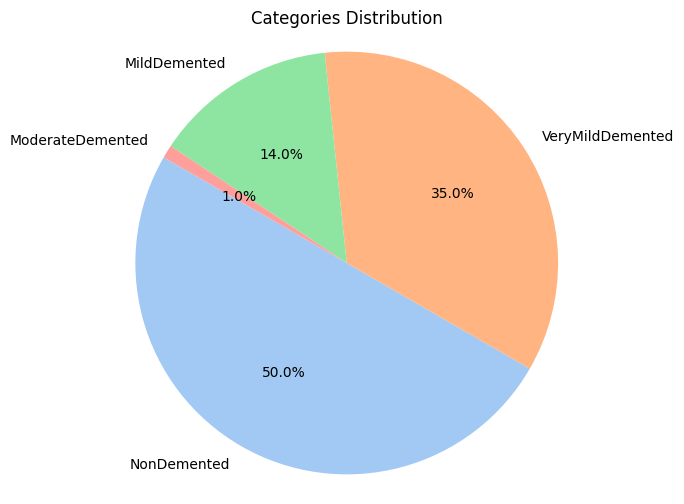

In [ ]:
# TODO: Count the number of entries in each category of the 'category' column
category_counts = alzheimer_df["category"].value_counts()
# TODO: Create a pie chart showing the distribution of categories
colors = sns.color_palette("pastel", n_colors=len(category_counts))
plt.figure(figsize=(6, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors = colors, startangle=150)
plt.axis('equal')
# TODO: Add a title to your chart
plt.title('Categories Distribution')
# TODO: Display the chart
plt.show()


###1.2.2 See Images [2 points] (2 manually graded points)
Let's take a look at some of these images. For each category, randomly select one image from the DataFrame. Load the image and display it. Arrange the images side-by-side in a single row. When you open the image, convert to RGB mode. Don't forget to add the category name as a title above each image and remove the axis lines!

(Make sure the entire figure is wide enough so all images are clearly visible in one row.)


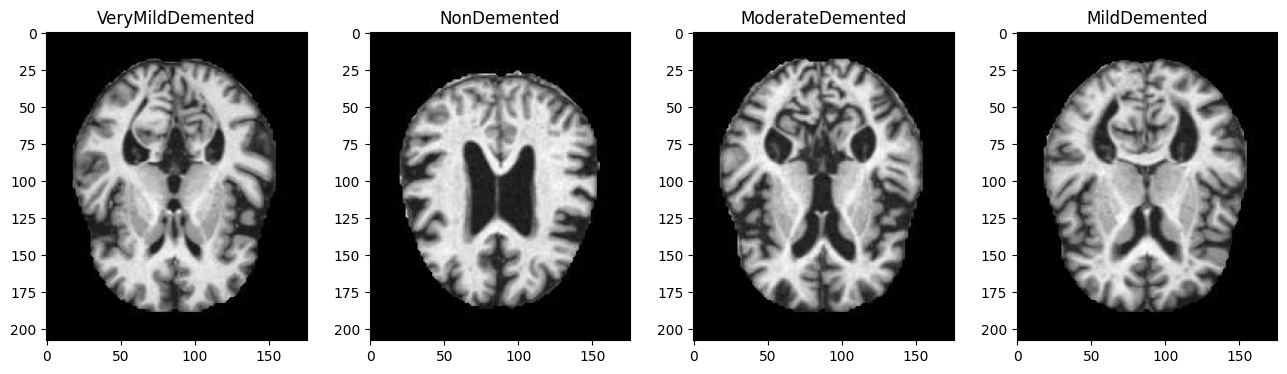

In [ ]:
# TODO: Create a list of class names to visualize
class_names = alzheimer_df["category"].unique()
plt.figure(figsize=(4 * len(class_names), 4))
# TODO: Loop through each class and display a sample image from that class
for i, class_name in enumerate(class_names):
    # TODO: Filter the DataFrame for the current class and sample one row
    sample_row = alzheimer_df[alzheimer_df["category"] == class_name].sample(n=1)
    # TODO: Open the image and convert to RGB mode
    image_path = sample_row["image_path"].values[0]
    image = Image.open(image_path).convert("RGB")
    # TODO: Display the image in a subplot with the class name as the title
    plt.subplot(1, len(class_names), i + 1)
    plt.imshow(image)
    plt.title(class_name)
    # plt.axis('off')
plt.show()


## **1.3** Feature Engineering [2 pts]

###1.3.1 Ordinal Encoding [2 points]
You might have noticed the images have string labels, however, we need to convert these into numerical labels so they can be used in our models.

* Apply Ordinal Encoding to the column `category` using the ordering `['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']`. Add this as a new column, `label`.
* Save results in `alzheimer_df`.

In [ ]:
# TODO: Identify the columns that represent ordered categories and store them in ordered_features
ordered_features = ["category"]
# TODO: Extract the ordering of each ordered feature and place them in a list.
ordered_categories = [['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']]
# TODO: Apply Ordinal Encoding to ordered columns in the dataset.
encoder = OrdinalEncoder(categories = ordered_categories)
alzheimer_df["label"] = encoder.fit_transform(alzheimer_df[ordered_features]) # alzheimer_df["category"]Series alzheimer_df[["category"]]DataFrame

In [ ]:
# Grader Cell (2 points)
grader.grade(test_case_id='ord_encodings', answer=alzheimer_df)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.4** Train Test Split [3 pts]

### 1.4.1 Train Test Split [3 points]
We will now split the original data into train and test sets, before the augmentation step. Using the `alzheimer_df` DataFrame, split your data into a training and testing set using sklearn's train_test_split function.

Ensure you:

*  Stratify by the label column (which contains the encoded disease stages).

*  Shuffle the data during the split.

*  Allocate 20% of the data to the testing set.

*  Use the provided random seed—do not change it.

Save your outputs to the following variables (do not rename them):
`train_set`, `test_set`

In [ ]:
# DO NOT CHANGE ----------------------------------------------------------------
SEED = 42
# DO NOT CHANGE ----------------------------------------------------------------

# TODO: Split the data into training and testing sets. Set the random_state = SEED.
train_set, test_set = train_test_split(alzheimer_df, stratify = alzheimer_df["label"], shuffle = True, test_size = 0.2, random_state = SEED)

In [ ]:
# Grader Cell (3 points)
grader.grade(test_case_id='train_test', answer=(train_set.shape, test_set.shape, train_set['label'].value_counts(normalize=True).sort_index().values.sum(), test_set['label'].value_counts(normalize=True).sort_index().values.sum()))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.5** Image Preprocessing, Initialize Dataloader [4 pts]

###1.5.1 Image Preprocessing [0 points]

In this section, the images undergo several preprocessing steps to ensure consistency and enhance the training process. Since the original MRI images come in varying resolutions, a center crop is applied after resizing to focus on the most relevant part of each image. This standardizes the input size for the model while preserving important features.

For the training set, data augmentation is employed to increase variability and improve model generalization. Specifically, for each original training image, four augmented copies are generated using transformations such as shifts, rotations, brightness/contrast adjustments, and color jittering. These augmentations help simulate different conditions and viewpoints, thereby expanding the dataset.

It is important to note that these augmentation techniques are applied only to the training images. The test images remain unaugmented and retain their original form (after center cropping), ensuring that model evaluation is performed on realistic data that reflects true conditions.

In [ ]:
import os
import cv2
import pandas as pd
import torch

def generate_augmented_images(df, transform, output_dir, num_augmented=1):
    """
    Generates augmented and center-cropped images from the original images in the DataFrame,
    saves them to disk, and returns a new DataFrame with updated file paths and labels.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'image_path', 'category', and 'label' columns.
        transform: An Albumentations transform pipeline (e.g., combined_transform) that outputs a tensor image.
        output_dir (str): Directory where augmented images will be saved.
        num_augmented (int): Number of augmented versions to create per original image.

    Returns:
        pd.DataFrame: A new DataFrame with columns 'image_path', 'category', and 'label'
                      for the augmented images.
    """
    # Create output directory if it doesn't exist.
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    new_data = []

    # Loop over each row in the DataFrame.
    for idx, row in df.iterrows():
        image_path = row['image_path']
        category = row['category']
        label = row['label']

        # Load the image using OpenCV.
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not load image at {image_path}. Skipping.")
            continue

        # Convert image from BGR (OpenCV's default) to RGB for consistency.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Generate the specified number of augmented images.
        for i in range(num_augmented):
            augmented = transform(image=image)
            aug_image = augmented['image']

            # Check if the output is a torch tensor (from ToTensorV2), then convert back to NumPy array.
            if torch.is_tensor(aug_image):
                # Normalization parameters must match those used in the transform.
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]

                # Convert tensor (C, H, W) to numpy array (H, W, C).
                aug_image = aug_image.detach().cpu().numpy().transpose(1, 2, 0)

                # Undo normalization: (value * std) + mean, then scale to [0, 255].
                aug_image = aug_image * std + mean
                aug_image = (aug_image * 255).clip(0, 255).astype('uint8')

                # Convert from RGB back to BGR as OpenCV expects BGR for saving.
                aug_image = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)

            # Create a unique filename for the augmented image.
            base_name = os.path.basename(image_path)
            file_name, ext = os.path.splitext(base_name)
            new_filename = f"{file_name}_aug_{i}{ext}"
            new_filepath = os.path.join(output_dir, new_filename)

            # Save the augmented image.
            cv2.imwrite(new_filepath, aug_image)

            # Append the new image info to the list.
            new_data.append({
                'image_path': new_filepath,
                'category': category,
                'label': label
            })

    # Create and return a new DataFrame from the augmented images' metadata.
    augmented_df = pd.DataFrame(new_data)
    return augmented_df


In [ ]:
combined_transform = A.Compose([
    A.Resize(height=180, width=180),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(),
    A.CenterCrop(height=128, width=128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Define the output directory for saving augmented images.
output_directory = 'augmented_images'

# Generate 4 augmented copies per original image.
augmented_df = generate_augmented_images(
    df=train_set,
    transform=combined_transform,
    output_dir=output_directory,
    num_augmented=4
)

updated_train_df = augmented_df

# Display information about the new DataFrame.
print("Original DF size:", len(train_set))
print("Updated DF size:", len(updated_train_df))
print(updated_train_df.head())


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Original DF size: 5120
Updated DF size: 20480
                              image_path     category  label
0  augmented_images/nonDem2055_aug_0.jpg  NonDemented    0.0
1  augmented_images/nonDem2055_aug_1.jpg  NonDemented    0.0
2  augmented_images/nonDem2055_aug_2.jpg  NonDemented    0.0
3  augmented_images/nonDem2055_aug_3.jpg  NonDemented    0.0
4     augmented_images/28 (42)_aug_0.jpg  NonDemented    0.0


In [ ]:
test_transform = A.Compose([
    A.Resize(height=180, width=180),
    A.CenterCrop(height=128, width=128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


test_output_directory = 'center_cropped_test_images'
updated_test_df = generate_augmented_images(
    df=test_set,
    transform=test_transform,
    output_dir=test_output_directory,
    num_augmented=1
)

print("Original Test Set size:", len(test_set))
print("Center Cropped Test Set size:", len(updated_test_df))
print(updated_test_df.head())

Original Test Set size: 1280
Center Cropped Test Set size: 1280
                                          image_path          category  label
0       center_cropped_test_images/28 (63)_aug_0.jpg  VeryMildDemented    1.0
1  center_cropped_test_images/verymildDem352_aug_...  VeryMildDemented    1.0
2     center_cropped_test_images/nonDem330_aug_0.jpg       NonDemented    0.0
3  center_cropped_test_images/verymildDem887_aug_...  VeryMildDemented    1.0
4    center_cropped_test_images/mildDem470_aug_0.jpg      MildDemented    2.0


In [ ]:
def load_and_preprocess_image(row):
  """Loads an image from a file path, preprocesses it, and returns the processed data."""
  try:
    image = cv2.imread(row['image_path'])
    if image is None:
      print(f"Warning: Could not load image at {row['image_path']}. Returning None.")
      return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Add any additional preprocessing steps you need here (e.g., resizing, normalization)
    return image
  except Exception as e:
    print(f"Error processing image {row['image_path']}: {e}")
    return None


# Apply the function to each row in the DataFrame
updated_train_df['image_data'] = updated_train_df.apply(load_and_preprocess_image, axis=1)
updated_test_df['image_data'] = updated_test_df.apply(load_and_preprocess_image, axis=1)

# Drop the 'image_path' and 'category' columns
updated_train_df = updated_train_df.drop(['image_path', 'category'], axis=1)
updated_test_df = updated_test_df.drop(['image_path', 'category'], axis=1)

# Remove rows with None image data (if any)
updated_train_df = updated_train_df.dropna(subset=['image_data'])
updated_test_df = updated_test_df.dropna(subset=['image_data'])

print("Updated Train DF after preprocessing:")
print(updated_train_df.head())
print("Updated Test DF after preprocessing:")
print(updated_test_df.head())


Updated Train DF after preprocessing:
   label                                         image_data
0    0.0  [[[17, 19, 18], [16, 18, 17], [17, 19, 18], [1...
1    0.0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
2    0.0  [[[17, 17, 15], [17, 17, 15], [16, 18, 17], [1...
3    0.0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
4    0.0  [[[4, 4, 4], [4, 4, 4], [4, 4, 4], [4, 4, 4], ...
Updated Test DF after preprocessing:
   label                                         image_data
0    1.0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
1    1.0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
2    0.0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
3    1.0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
4    2.0  [[[0, 0, 0], [0, 0, 0], [1, 1, 1], [0, 0, 0], ...


Let's take a look at the results of our augmentation!

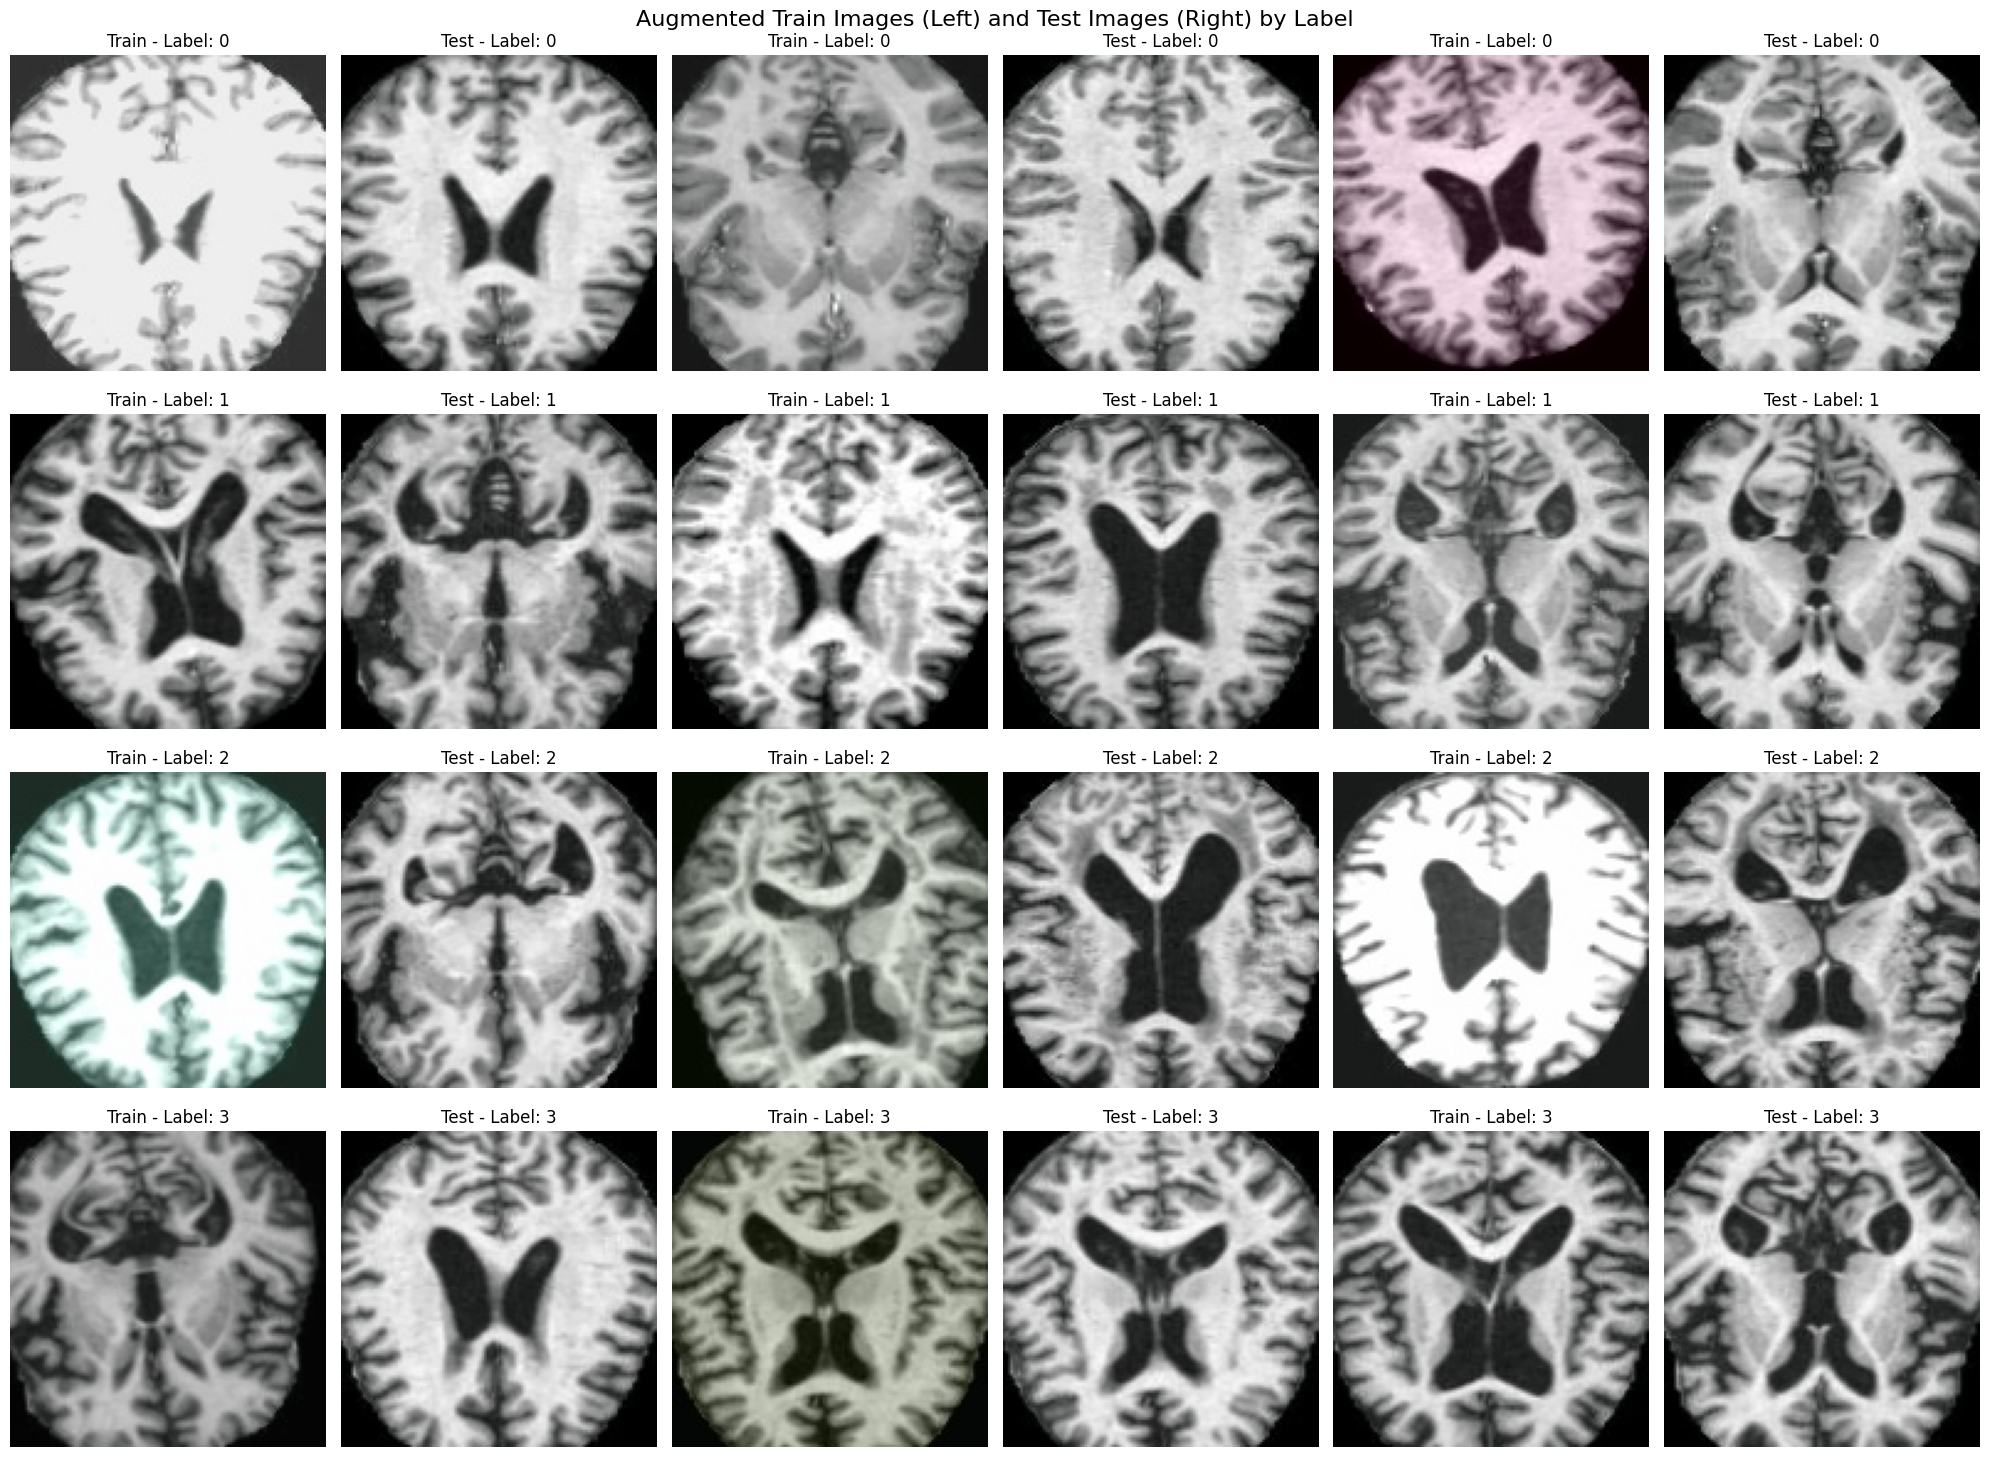

In [ ]:
import matplotlib.pyplot as plt

def display_image_grid(train_df, test_df, num_images_per_class=3):
  """Displays a grid of images from the train and test datasets, organized by class."""

  fig, axes = plt.subplots(4, num_images_per_class * 2, figsize=(20, 15))
  fig.suptitle("Augmented Train Images (Left) and Test Images (Right) by Label", fontsize=16)

  for label in range(4):
    train_images = train_df[train_df['label'] == label].sample(n=num_images_per_class, random_state=42)
    test_images = test_df[test_df['label'] == label].sample(n=num_images_per_class, random_state=42)

    for i in range(num_images_per_class):
      # Train image
      ax = axes[label, i * 2]
      ax.imshow(train_images.iloc[i]['image_data'])
      ax.set_title(f"Train - Label: {label}")
      ax.axis('off')

      # Test image
      ax = axes[label, i * 2 + 1]
      ax.imshow(test_images.iloc[i]['image_data'])
      ax.set_title(f"Test - Label: {label}")
      ax.axis('off')

  plt.tight_layout()
  plt.show()

# Call the function to display the image grid
display_image_grid(updated_train_df, updated_test_df)


###1.5.2 Initialize Dataloader [4 points]

Implement the `AlzheimerDataset` class below. Then, create the train and test datasets using `AlzheimerDataset`, and initialize DataLoaders, named train_loader and test_loader for the training and testing set, respectively. Note that you should
have these parameters for the initialization:

Train: batch_size = 32, shuffle = True

Test: batch_size = 32, shuffle = False

Don't forget to initialize the `classes` variable!

In [ ]:
class AlzheimerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # TODO: Store the dataframe and transform
        # TODO: Initialize a new variable, classes, which
        # is the unique labels in dataframe
        self.dataframe = dataframe
        self.transform = transform
        self.classes = sorted(dataframe['label'].unique())

    def __len__(self):
        # TODO: Return the number of samples in the dataframe
        return len(self.dataframe)

    def __getitem__(self, idx):
        # TODO: Get image and label at the given index
        # TODO: Apply any transforms (if provided)
        # TODO: Return the image and label
        image = self.dataframe.loc[idx, 'image_data']
        label = self.dataframe.loc[idx, 'label']
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

# TODO: Create train and test datasets using AlzheimerDataset
train_dataset = AlzheimerDataset(updated_train_df)
test_dataset = AlzheimerDataset(updated_test_df)

# TODO: Create DataLoaders for train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Grader Cell (4 points)
trainLoaderCheck = [getattr(train_dataloader, "batch_size"),
str(type(train_dataloader)),
len(getattr(train_dataloader, "dataset"))]
testLoaderCheck = [getattr(test_dataloader, "batch_size"),
str(type(test_dataloader)),
len(getattr(test_dataloader, "dataset"))]

grader.grade(test_case_id = 'check_dataloader', answer = (trainLoaderCheck, testLoaderCheck))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# **Part 2:** Classification Models [23 points] (8 points - Manually Graded)

We now have the data needed to train a multi-class object classifier. We will start simple with a logistic regression classifier as a baseline for our performance, before we move onto more complex models.

In this case, we are looking at the remaining part in the pipeline which were grayed out before as follows:

<div>
<img src="https://s2.loli.net/2023/03/30/ZCBFQvkXuoJpI8K.png", width = "800"/>
</div>

Diagram Reference: [Link](https://www.kaggle.com/code/uvxy1234/cifar-10-implementation-with-pytorch)

Note: For ALL logistic regression, think about what the implication of using the criterion CrossEntropyLoss(), and whether that means you need to include an activation layer at the end of your architectures.

## 2.1 Multimonial Logical Logistic Regression - Baseline [11 points] (4 points - Manually Graded)

Let's first try solving this problem with a Multimonial Logistic Regression classifier.

We want to use a Multimonial Logistic Regression, since we're looking to predict between 4 different levels of dementia.

We will define a logistic regression model in Pytorch and train it on our training set and evaluate the performance on the test set.

Logistic regression can be modeled as a function that can take in any number of inputs and constrain the output to be between 0 and 1. This means we can think of Logistic Regression as a one-layer neural network without hidden layers with some activation function. Think about how working with multiple classes may require you to think past a traditional Logistic Regression Model to optimize on performance!

<div>
<img src='https://i.stack.imgur.com/fKvva.png',width='600'/>
</div>

### 2.1.1 Logistic Regression Model Architecture (5 points)

We will define our first model in Pytorch. Read up about how to define and use layers in a Pytorch neural network [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

Our first model is a logistic regression model with the number of outputs equal to the number of classes in the model. Please implement the constructor for the `LogReg` class (the `__init__` function below) with the definition of the logistic regression model.

When implementing this section, please think about what activation function would be most appropriate for logistic regression.

Note that each data sample is in the shape (128, 128, 3). The goal of our architecture is to flatten each image completely.

In addition, when constructing your architecture, be mindful of what your input and output dimensions should be for `in_features` and `out_features` based off the image dimensions!



In [ ]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: initialize the neural network layers
        # Make sure to include a flatten layer in the init() instead of using a view in the forward() function
        input_dim = 128 * 128 * 3
        output_dim = 4
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features = input_dim, out_features = output_dim)
        # END TODO

    def forward(self, x):
        x = x.type(torch.float32)
        # TODO: implement the operations on input data
        # Hint: think of the neural network architecture for logistic regression
        x = self.flatten(x)
        outputs = self.linear(x)
        # END TODO
        return outputs

Let's print the model summary

In [ ]:
LogReg()

LogReg(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=49152, out_features=4, bias=True)
)

In [ ]:
#Grader Cell (5 points)
grader.grade(test_case_id = 'logistic_regression_model', answer = str(LogReg()))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Notes:** Getting full credit for the above test case doesn't necessarily ensure that your model will perform well on the test dataset as it only evaluates the structure of your neural network.

If you don't achieve complete credit for accuracy and loss on the test dataset, you may need to modify your architecture.

### 2.1.2 Training Logistic Regression Model (4 points)
---
**TODOs:**
1.   Instantiate the Logistic regression to the variable `logreg`. Make sure to send this to the GPU device.

2.   Set the loss criterion as `CrossEntropyLoss` (you can look up the documentation [here](https://pytorch.org/docs/stable/nn.html#loss-functions)). Note that softmax is already built into CrossEntropyLoss so if you use CrossEntropyLoss as the loss criterion, you don't need to add an additional softmax layer.

3.   Fill in the missing parts in the training loop (see `#TODO` comments below)
4.   Save the Training Accuracy for every epoch into the variable `acc_LIST_log`.
5.   Save the Average Loss for every epoch into the variable `loss_LIST_log`.
---
The optimizer is set as Adam -- **please do not modify the optimizer**.

Hint: Remember to update the weights correctly by backpropagation, please zero out the gradients by calling `optimizer.zero_grad()` every time you call `backward()`.

**Note: If the loss went up during the training, there is something wrong with the model, so you should check if the model is implemented correctly**

In [ ]:
%%time
# Sending the data to device (CPU or GPU)
# TODO: (1) instantiate the logistic regression to variable logreg, (2) set the loss criterion as CrossEntropyLoss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logreg = LogReg().to(device)
criterion = nn.CrossEntropyLoss()
# END TODO
optimizer = optim.Adam(logreg.parameters(), lr=1e-4) #lr - learning step
epoch = 10

loss_LIST_log = []
acc_LIST_log = []

# Train the Logistic Regression
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_dataloader:
      labels = labels.type(torch.LongTensor)
      inputs, labels = inputs.to(device), labels.to(device)

      # TODO
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = logreg(inputs)
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct prediction and add to correct and total
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      total += labels.size(0)
      correct += (predicted == labels).sum()

  # Step 9: Calculate training accuracy for each epoch and add to acc_LIST_log
  accuracy = 100 * correct / total # must * 100
  acc_LIST_log.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_log
  avg_loss = running_loss / len(train_dataloader)
  loss_LIST_log.append(avg_loss)
  # END TODO

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_dataloader), accuracy))

The loss for Epoch 0 is: 81.08745023161173, Accuracy = 45.3173828125
The loss for Epoch 1 is: 59.41747094318271, Accuracy = 49.0966796875
The loss for Epoch 2 is: 52.969605492055415, Accuracy = 50.9912109375
The loss for Epoch 3 is: 55.47925369367003, Accuracy = 51.42578125
The loss for Epoch 4 is: 48.4479747697711, Accuracy = 53.1103515625
The loss for Epoch 5 is: 47.98475684523582, Accuracy = 53.8427734375
The loss for Epoch 6 is: 49.0145273141563, Accuracy = 54.7998046875
The loss for Epoch 7 is: 49.00869191214442, Accuracy = 54.5654296875
The loss for Epoch 8 is: 47.46629277840257, Accuracy = 54.7314453125
The loss for Epoch 9 is: 43.862359543144706, Accuracy = 56.7138671875
CPU times: user 20.9 s, sys: 810 ms, total: 21.7 s
Wall time: 24.1 s


In [ ]:
# (if applicable)
# In order to pass the AutoGrader, every element in “acc_LIST_log” should be a float.
# If the elements are of type “Tensor”, convert each element into type FLOAT by using .item() or .tolist()
# To check if each element is a Tensor, print out “acc_LIST_log” and see if there is a Tensor() wrapped around each element.
acc_LIST_log = [x.tolist() for x in acc_LIST_log]

In [ ]:
#Grader Cell (4 points)
grader.grade(test_case_id = 'log_train_loss', answer = (acc_LIST_log, loss_LIST_log))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.1.3 Plotting Training Accuracy vs Epochs for Logistic Regression (4 points - Manually Graded)

---
**TODO:**

Plot the training accuracy vs epochs.

Chart Specifications:
1. The accuracy should be in the y-axis and epochs in x-axis.
2. Add chart title.
3. Epoch label should start with 1 (for audience interpretability).
4. To avoid "File Too Large" for submission, please set figure size to (5,3).
---

Text(0.5, 1.0, 'Training Accuracy vs Epochs')

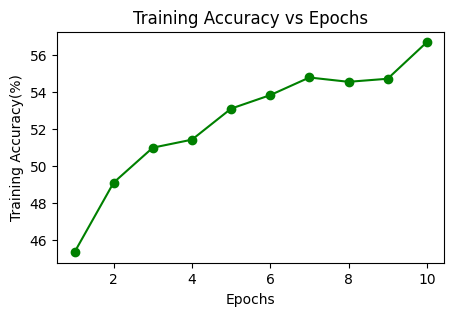

In [ ]:
# TODO
plt.figure(figsize=(5,3))
epochs_x = list(range(1, len(acc_LIST_log) + 1))
plt.plot(epochs_x, acc_LIST_log, marker='o', linestyle='-', color='g')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy(%)')
plt.title('Training Accuracy vs Epochs')
# END TODO

### 2.1.4 Logistic Regression Model Accuracy (2 points)

Calculate the Test Accuracy for the Logistic Regression Model we trained above.

This should be similar to how we calculated training accuracy above.

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        # TODO
        # Get the output using your logreg model
        outputs = logreg(images)
        # Get the prediction using argmax
        _, predicted = torch.max(outputs, 1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum()

# Calculate test accuracy for logistic regression (should multiple by 100)
test_acc_log = 100 * correct / total

# TODO END
print('Test Accuracy: ' + str(test_acc_log.item()))

Test Accuracy: 71.171875


In [ ]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'logistic_regression_test_acc', answer = test_acc_log.item())

You earned 0/2 points.

Your accuracy is either too high or too lowDon't worry, you can re-submit and we will keep only your latest score.


## 2.2 Feedforward Neural Networks [12 points] (4 points - Manually Graded)

<div>
<img src='https://s2.loli.net/2022/11/21/dvqstVUzcQPChD1.png', width='400'/>
</div>

**NOTE:** For 2.2,1, getting full points on the autograder for certain test cases may not be indicative of correctness; there may be slight inaccuracies in how your structured/architectured your model, or errors in your forwards. Losing points in the autograder can most likely be attributed to this.

Since logistic regression isn't that great at the classification problem, we need more representation power in our model. We will try and define a feedforward neural network.

### 2.2.1 FNN Architecture (4 points)


Now, complete the *FNN* class below to define a feedforward neural network architecture with **only 1 hidden layers with ```out_features``` of 256**. Note that the last layer must have the same number of classes as the output size! When implementing this model, please think about what activation function would be most appropriate for each layer in this classifier.

In [ ]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: initialize the neural network layers
        input_dim = 128 * 128 * 3
        output_dim = 4
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features = input_dim, out_features = 256)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 256, out_features = output_dim)
        # END TODO

    def forward(self, x):
        x = x.type(torch.float32)
        # TODO: implement the operations on input data
        # Hint: think of the neural network architecture for FNN
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        outputs = self.linear2(x)
        # END TODO
        return outputs

Let's print the model summary

In [ ]:
FNN()

FNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=49152, out_features=256, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
#Grader Cell (4 points)
grader.grade(test_case_id = 'feedforward_nn_model', answer = str(FNN()))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2.2 Feedforward Neural Network Architecture Training (6 points)

And now, let's define another training loop to take in the raw data. The training loop should be largely identical to the previous training loop created.


1.   Define a new FNN model using the `FNN` class defined above and save the model as `fnn`. (Make sure to save to the correct device)
2.   Use the same criterion and parameters as before.
3.   Save the accuracy and loss to `acc_LIST_FNN` and `loss_LIST_FNN` respectively



In [ ]:
%%time
# Sending the data to device (CPU or GPU)
# TODO
fnn = FNN().to(device)
criterion = nn.CrossEntropyLoss()
# END TODO
optimizer = optim.Adam(fnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_dataloader:
      labels = labels.type(torch.LongTensor)
      inputs, labels = inputs.to(device), labels.to(device)

      # TODO
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = fnn(inputs)
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct prediction and add to correct and total
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      total += labels.size(0)
      correct += (predicted == labels).sum()

  # Step 9: Calculate training accuracy for each epoch and add to acc_LIST_FNN
  accuracy = 100 * correct / total
  acc_LIST_FNN.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN
  avg_loss = running_loss / len(train_dataloader)
  loss_LIST_FNN.append(avg_loss)
  # END TODO

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_dataloader), accuracy))


The loss for Epoch 0 is: 70.82250379398465, Accuracy = 44.853515625
The loss for Epoch 1 is: 49.49452242255211, Accuracy = 48.0029296875
The loss for Epoch 2 is: 30.247276001796127, Accuracy = 50.6884765625
The loss for Epoch 3 is: 25.83940482586622, Accuracy = 52.2412109375
The loss for Epoch 4 is: 20.94940092973411, Accuracy = 52.6513671875
The loss for Epoch 5 is: 15.170126654207706, Accuracy = 53.96484375
The loss for Epoch 6 is: 10.959871941246092, Accuracy = 55.068359375
The loss for Epoch 7 is: 8.303291246574371, Accuracy = 55.8935546875
The loss for Epoch 8 is: 7.340865038894117, Accuracy = 54.5751953125
The loss for Epoch 9 is: 5.0980082301422955, Accuracy = 56.4794921875
CPU times: user 41.8 s, sys: 301 ms, total: 42.1 s
Wall time: 42.7 s


In [ ]:
acc_LIST_FNN = [x.tolist() for x in acc_LIST_FNN]

In [ ]:
#Grader Cell (6 points)
grader.grade(test_case_id = 'fnn_train_loss', answer = (acc_LIST_FNN, loss_LIST_FNN))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2.3 Plotting Training Accuracy vs Epochs FNN (4 points - Manually Graded)

---
**TODO:**

Plot the training accuracy vs epochs for the FNN model.

Chart Specifications:
1. The accuracy should be in the y-axis and epochs in x-axis.
2. Add chart title.
3. Epoch label should start with 1 (for audience interpretability).
4. To avoid "File Too Large" for submission, please set figure size to (5,3).
---

Text(0.5, 1.0, 'Feedforward Neural Network Training Accuracy vs Epochs')

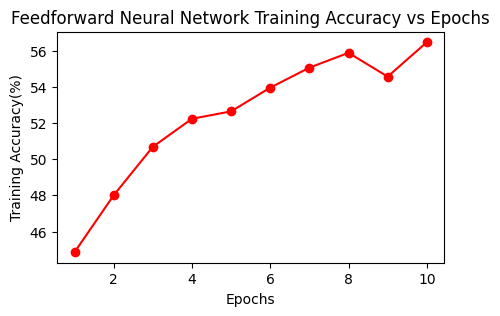

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# TODO
plt.figure(figsize=(5,3))
epochs_x = list(range(1, len(acc_LIST_FNN) + 1))
plt.plot(epochs_x, acc_LIST_FNN, marker='o', linestyle='-', color='r')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy(%)')
plt.title('Feedforward Neural Network Training Accuracy vs Epochs')
# END TODO

### 2.2.4 FNN Model Accuracy (2 points)

Calculate the Test Accuracy for the three FNN Model we trained above (the technique for doing this is the same as computing the test accuracy for the logistic regression classifier above).

Remember, your model should be named `fnn`.

In [ ]:
total = 0
correct_fnn = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        # TODO
        # Get the output
        outputs = fnn(images)
        # Get the prediction using argmax
        _, predicted = torch.max(outputs, 1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct_fnn += (predicted == labels).sum()

# Calculate test accuracy for FNN (should multiple by 100)
test_acc_FNN = 100 * correct_fnn / total

# TODO END
print('Test Accuracy: ' + str(test_acc_FNN.item()))


Test Accuracy: 73.828125


In [ ]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'feedforward_nn_acc', answer = (test_acc_FNN.item(), loss_LIST_FNN))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#Part 3: Convolutional Neural Networks [30 points, 3 manually graded]


###3.1: Calculating output dimensions of CNN (3 points)

In this section, we will use Convolution Neural Networks to create a model for our MRI dataset.

Before we start building the architecture, it's important to understand the dimensions of the feature maps produced in each of the convolution and pooling layers. We want to keep track of this information as once we get to the fully-connected layers, we need to specify the number of input parameters.

Let's first build a function that will help us calculate the dimensions based on the input parameters.


Since we are working with squared image, we will build just one function that can be used to calculate both the H (height) and W (width) of the feature map.

Below is the function used to calculate the output dimension of the feature map:

<div>
<img src='https://s2.loli.net/2023/03/30/lKpjPLVHcuRC8n2.png',width='300'/>
</div>

Diagram Reference: [Link](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

---
**TODO:**

Build the **feature_map_dim** function, which takes in the following four parameters and return the dimension of the output feature map.

- **input_dim**: height/width of the input image

- **kernel_size**: size of the convolving kernel (aka. filter)

- **padding**: padding added to all four sides of the input in order to preserve the edges/borders

- **stride**: Stride of the convolution, or how many shifts per kernel
  
ROUND DOWN if the result if a fraction.

---

Notice there is another parameter, "dilation", which is the spacing between kernel elements. We have not covered this in class; simply set it to 1.

In [ ]:
import math

def feature_map_dim(input_dim, padding, kernel_size, stride):
  '''
  The function takes in the following four parameters and return the dimension of the output feature map.

  input_dim: height/width of the input image
  kernel_size: size of the convolving kernel (aka. filter)
  padding: padding added to all four sides of the input in order to preserve the edges/borders
  stride: Stride of the convolution, or how many shifts per kernel

  ROUND DOWN if the result if a fraction.

  Notice there is another parameter, "dilation", which is the spacing between kernel elements. We have not covered this in class; simply set it to 1
  '''
  ## TODO:
  output_dim = (input_dim + 2 * padding - (kernel_size - 1) - 1) // stride + 1
  ## END TODO
  return output_dim

In [ ]:
student_ans_1 = feature_map_dim(28, 1, 3, 1)
student_ans_2 = feature_map_dim(28, 2, 4, 2)
student_ans_3 = feature_map_dim(17, 0, 2, 2)

In [ ]:
#Grader Cell (3 points)
grader.grade(test_case_id = 'test_func_feature_map_dim', answer = ([student_ans_1, student_ans_2, student_ans_3]))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


###3.2: Creating Custom CNN Architecture (12 points)

---
**TODOs:**

`def __init__(self)`::
1.  Initialize some number of `convolutional blocks` (consists of a convolution layer, an activation function, and a Pooling layer)

2. `Flatten` the output of the convolution to a tensor

3. Initialize some number of `fully-connected layers`

`def forward(self, x)`:
4. Build the `forward` function/path with the layers initialized in `__init__` function.

---

- **Note:** While parameters of convolution layers tend to vary, it is possible to use the same pooling layer and activation function in each block. If you intend to use the same parameters for these two elements, then only 1 pooling layer and 1 activation function needs to be initialized.
- **Hint 1**: Use the `feature_map_dim` function, and the input_dim and output_dim comments to help you keep track of the input/output dimensions of each layer
- **Hint 2**: The parameters you've calculated is particularly useful for the input dimensions for the linear layer in the first fully-connected layer.
- **Hint 3**: Each input is an RGB (3 channel) 32 x 32 image.
- **Hint 4**: The final fully-connected layer's output dimension should be the same as the number of classes in our dataset.
- **Hint 5**: In order to raise the accuracy of the model, you can consider using some of the following strategies (see Lecture slides for more info):
    * Use [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) or [`nn.LayerNorm`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) in between the layers (after convolutional layer but before the activation function)
    * Implement residual connections (i.e., output of the block = input to the block + output of the last layer in the block)
    * Stack more blocks (e.g., Convolutional layers, Convolutional layers + Batch Normalization)

You will have a lot more freedom with this section to make your own architecture, and you only need a few of the basic blocks to pass the autograder, but you may need to come back and add to the architecture if your accuracy ends up being too low.

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # TODO
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(16) # 16 is out_channels
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.fc1 = nn.Linear(32768, 128)
    self.fc2 = nn.Linear(128, 4)

  def forward(self, x):
    # TODO
    x = self.conv1(x) # 16X32X32
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool(x) # 16X16X16
    x = self.conv2(x) # 32X16X16
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool(x) # 32X8X8
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

In [ ]:
CNN()

CNN(
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
#Grader Cell (12 points)
grader.grade(test_case_id = 'cnn_model', answer = str(CNN()))

Correct! You earned 12/12 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.3 Training CNN Model (10 points)

---
**TODOs**
1.   Instantiate the CNN to the variable `cnn` (make sure to send this to the device env)
2.   Set the criterion as a CrossEntropyLoss (you can look up the documentation [here](https://pytorch.org/docs/stable/nn.html#loss-functions))
3.   Fill in the missing parts in the training loop.
4.   Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called accuracy
5.   Save the Training Accuracy for every epoch into `acc_LIST_CNN`
6.   Save the Average Loss for every epoch into `loss_LIST_CNN`

**Please do not modify the following set ups: **
- Optimizer: The optimizer is set as "Adam".
- Epoch: The epoch is set to "10".

---

**Hint:** Remember to update the weights correctly by backpropagation, please zero out the gradients by calling `optimizer.zero_grad()` every time you call `backward()`. Please review the `Recitation 10` for detailed instructions on how to perform these operations.

**Note 1**: If the loss went up during the training, there is something wrong with the model, so you should check if the model is implemented correctly.

**Note 2**: Training time may take up to a few minutes.

**Note 3**: `acc_LIST_CNN` and `loss_LIST_CNN` should contain data of type float not tensor.

In [ ]:
from tqdm import tqdm

In [ ]:
# Sending the data to device (CPU or GPU), and setting loss criterion
# TODO
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
# END TODO
optimizer = optim.Adam(cnn.parameters(), lr=1e-4) #lr - learning rate
epoch = 10

acc_LIST_CNN = []
loss_LIST_CNN = []

# Train the CNN
for epoch in tqdm(range(epoch)):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_dataloader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.permute(0, 3, 1, 2).float().to(device), labels.to(device)
      # TODO
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = cnn(inputs)
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a backpropagation
      loss.backward()
      # Step 6: Update the weight using the gradients from backpropagation
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct predictions and increment the number of correct and total predictions after this batch
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      total += labels.size(0)
      correct += (predicted == labels).sum()

  # Step 9: Calculate training accuracy for each epoch, store in variable 'accuracy', and add to acc_LIST_CNN
  accuracy = 100 * correct / total
  acc_LIST_CNN.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_CNN
  avg_loss = running_loss / len(train_dataloader)
  loss_LIST_CNN.append(avg_loss)
  # END TODO
  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_dataloader), accuracy))


 10%|█         | 1/10 [00:08<01:20,  8.98s/it]

The loss for Epoch 0 is: 0.9256669110618532, Accuracy = 55.9716796875


 20%|██        | 2/10 [00:17<01:07,  8.48s/it]

The loss for Epoch 1 is: 0.7568090727552772, Accuracy = 65.8642578125


 30%|███       | 3/10 [00:25<00:57,  8.26s/it]

The loss for Epoch 2 is: 0.6404840982053429, Accuracy = 72.16796875


 40%|████      | 4/10 [00:33<00:49,  8.23s/it]

The loss for Epoch 3 is: 0.5629618641454727, Accuracy = 75.6884765625


 50%|█████     | 5/10 [00:41<00:41,  8.20s/it]

The loss for Epoch 4 is: 0.5010488004190847, Accuracy = 78.095703125


 60%|██████    | 6/10 [00:49<00:33,  8.29s/it]

The loss for Epoch 5 is: 0.4533438815036789, Accuracy = 80.1904296875


 70%|███████   | 7/10 [00:58<00:24,  8.26s/it]

The loss for Epoch 6 is: 0.4119268963113427, Accuracy = 81.8603515625


 80%|████████  | 8/10 [01:06<00:16,  8.20s/it]

The loss for Epoch 7 is: 0.3796615310246125, Accuracy = 83.359375


 90%|█████████ | 9/10 [01:14<00:08,  8.21s/it]

The loss for Epoch 8 is: 0.3414765168796293, Accuracy = 85.2001953125


100%|██████████| 10/10 [01:22<00:00,  8.25s/it]

The loss for Epoch 9 is: 0.3193006616085768, Accuracy = 85.7958984375


In [ ]:
# In order to pass the AutoGrader, every element in "acc_LIST_CNN" should be a float.
# If the elements are of type "Tensor", convert each element into type FLOAT by using .item() or .tolist()
# To check if each element is a Tensor, print out "acc_LIST_CNN" and see if there is a Tensor() wrapped around each element.
acc_LIST_CNN = [x.item() for x in acc_LIST_CNN]


In [ ]:
#Grader Cell (10 points)
grader.grade(test_case_id = 'cnn_train_loss', answer = (acc_LIST_CNN, loss_LIST_CNN))

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.4 Plotting Training Accuracy vs Epochs CNN (Manually Graded, 3 points)
---
**TODO:**

Plot the training accuracy vs epochs.

Chart Specifications:
1. The accuracy should be in the y-axis and epochs in x-axis.
2. Add chart title.
3. Epoch label should start with 1 (for audience interpretability).
4. To avoid "File Too Large" for submission, please set figure size to (5,3).
---

Text(0.5, 1.0, 'Convolutional Neural Network Training Accuracy vs Epochs')

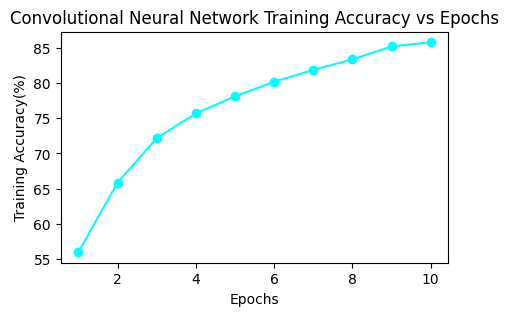

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# TODO
plt.figure(figsize=(5,3))
epochs_x = list(range(1, len(acc_LIST_CNN) + 1))
plt.plot(epochs_x, acc_LIST_CNN, marker='o', linestyle='-', color='cyan')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy(%)')
plt.title('Convolutional Neural Network Training Accuracy vs Epochs')
# END TODO

### 3.5 CNN Model Test Accuracy (2 points)

---
**TODO:**
Calculate the Test Accuracy for the CNN Model we trained above. Save it to the variable named `test_acc_CNN`. The technique for doing this is the same as computing the test accuracy for the logistic regression and FNN classifiers above.

---

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.permute(0, 3, 1, 2).float().to(device), labels.to(device)
        # TODO
        # Get the output
        outputs = cnn(images)
        # Get the prediction using argmax
        _, predicted = torch.max(outputs, 1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum()

# Calculate test accuracy for CNN (should multiple by 100)
test_acc_CNN = 100 * correct / total
# TODO END

print(f'Test Accuracy: ' + str(test_acc_CNN.item()))

Test Accuracy: 89.140625


In [ ]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'cnn_test_acc', answer = (test_acc_CNN.item()))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Part 4: LLMs (32 points, 0 manually graded)

Now we'll turn to prediction tasks with Large Language Models (LLMs). In the past few years, LLMs have fundamentally changed how we approach natural language processing tasks.

Unlike traditional machine learning models that might focus on specific, narrow tasks, LLMs can be applied to a wide range of applications through techniques like prompt engineering, few-shot learning, and zero-shot learning. In this section, we're going to explore how to leverage LLMs to tackle machine learning objectives in completely different ways!

## 4.1 Loading the Dataset

In this section, we'll be using the Youtube Comments dataset. This dataset consists of a series of comments under YouTube videos as well as the sentiment associated with them. We are going to use LLMs to predict the sentiments associated with a comment -- Sentiments Analysis, a classic Natural Language Processing (NLP) task!

In [ ]:
# Installing Dependencies
!pip install kagglehub pandas numpy

Let's load the dataset and examine it:

In [ ]:
import kagglehub
import os
import pandas as pd

# Download the dataset
path = kagglehub.dataset_download("atifaliak/youtube-comments-dataset")

# Load the CSV file
csv_file = os.listdir(path)[0]
file_path = os.path.join(path, csv_file)

# Read the CSV into a DataFrame
comments_df = pd.read_csv(file_path)

comments_df.dropna(inplace = True)

comments_df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


Let's examine the unique labels we have in the sentiments column.

In [ ]:
print("Unique sentiment labels:")
print(comments_df['Sentiment'].unique())

Unique sentiment labels:
['neutral' 'negative' 'positive']


## 4.2 Zero-Shot Learning (20 points)

Most of the machine learning models and deep learning models we work with involve a supervised training process, where labeled data are needed to train the model. However, LLMs are pre-trained on such large, unlabeled datasets such that their knowledge can be transfered to reach high performance on tasks previously unseen.

This unique ability of LLMs is called Zero-shot learning. Zero-shot learning in LLMs is a powerful capability that allows models to handle a wide range of tasks without prior task-specific training. It leverages pretraining knowledge and pattern recognition, making LLMs highly versatile.

Feel free to learn more about zero-shot learning here: https://huggingface.co/tasks/zero-shot-classification

Now, we're going to leverage zero-shot learning to try predicting the sentiments of the YouTube comments, and see how it performs.

We will be using the Groq API as the LLM provider for this task -- the client session has been initaited for you using the Groq Python SDK.

You will have to generate a **free tier Groq API key** on https://groq.com/, and **add that API key to Colab Secrets**. View this video for a tutorial on how to generate a free tier Groq API key:

https://youtu.be/EVr0r0wOLm8

Forn security purposes, generally, you should always configuer your API keys as a secret in environmental variables and **NEVER** release it to the public.


In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 5.5 MB/s eta 0:00:00


In [ ]:
from groq import Groq
from google.colab import userdata

# TODO: make sure that you have defined your GROQ_API_KEY in Colab Secrets!!!
# Tutorial: https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75
GROQ_API_KEY=userdata.get('GROQ_API_KEY')

client = Groq(
    api_key=GROQ_API_KEY
)

In [ ]:
#Grader Cell (5 points)

grader.grade(test_case_id = 'check_api_key', answer = GROQ_API_KEY)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now, you are going to define a function to call the Groq API with a prompt, such that it can predict the sentiments of given YouTube comments.

TODO:

1. Create a model response using chat completion
2. Use the llama3-70b-8192 as the LLM
3. Define a system prompt that unstructs the LLM to analyze the user prompt and classify the comment into the sentiment categories you printed in 4.1
4. Define the user prompt to be the function input
5. Unpack the response object, extract the model response text in lower-case and stripped from leading and trailing spaces
6. return the processed model response text

You might find this doumentation about the Chat Completions endpoint from Groq helpful here if you have not worked with Groq API before: https://console.groq.com/docs/quickstart

In [ ]:
def analyze_sentiment_zero_shot(comment):

# TODO

    # Create a model response using chat completion
    # Use the llama3-70b-8192 as the LLM
    LLM_model = "llama3-70b-8192"
    # Define a system prompt that unstructs the LLM to analyze the user prompt and classify the comment into the sentiment categories you printed in 4.1
    system_prompt = (
        "You are an expert in classifying the sentiment of YouTube comments. "
        "Your task is to categorize each comment into one of the following labels: positive, negative, or neutral.\n\n"
        "Please follow these detailed guidelines:\n"
        "- **positive**: The comment expresses praise, satisfaction, excitement, gratitude, or happiness.\n"
        "  Example phrases: 'This is amazing!', 'Loved every second', 'So helpful!', 'Great explanation'.\n\n"
        "- **negative**: The comment expresses complaints, disappointment, sarcasm, frustration, or criticism — even subtly. "
        "This includes:\n"
        "  • Negative comparisons (e.g., 'Much worse than before')\n"
        "  • Dissatisfaction or poor experience (e.g., 'Didn’t work for me', 'waste of time')\n"
        "  • Subtle or indirect negativity (e.g., 'I wasn't prepared for the start lol')\n"
        "  • Critical technical feedback or negative anecdotes (e.g., 'I had to work six years in that toxic job', 'Never got a proper day off')\n"
        "  • Negative or sarcastic tone (e.g., 'Nice job ruining it', 'Thanks for making it worse')\n\n"
        "- **neutral**: The comment states facts, asks questions, or does not clearly express positive or negative emotions.\n"
        "  Examples: 'This was uploaded yesterday.', 'What is the background music?', 'Watched it twice.'\n\n"
        "You must infer the underlying tone or emotional intent. Be especially careful with sarcasm, negative life experiences, and indirect complaints.\n"
        "Respond with only one word: positive, negative, or neutral. No explanation."
    )

    # Define the user prompt to be the function input
    user_prompt = f"Comment: {comment}"

    response = client.chat.completions.create(
        model=LLM_model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )
    # Unpack the response object, extract the model response text in lower-case and stripped from leading and trailing spaces
    model_response = response.choices[0].message.content.strip().lower()
    # Return the processed model response text
    return model_response

# ENDTODO

In [ ]:
#Grader Cell (6 points)

try:
  example_response_positive = analyze_sentiment_zero_shot("I absolutely love everything about this content!")
except Exception as e:
  example_response_positive = "error"

try:
  example_response_neutral = analyze_sentiment_zero_shot("I neither like nor dislike this content.")
except Exception as e:
  example_response_neutral = "error"

try:
  example_response_negative = analyze_sentiment_zero_shot("This content is absolutely horrible and I hate it.")
except Exception as e:
  example_response_negative = "error"

grader.grade(test_case_id = 'zero_shot_analysis', answer = (example_response_positive, example_response_neutral, example_response_negative))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now that the function to call Groq API has been defined, we are going to go ahead and apply it on our dataset. Our dataset is large -- consisting of more than 15,000 rows, which is a bit too large for our learning purposes. We are going to sample 30 entries from each sentiments class by sampling the first 30 entries of each sentiment class, and concatenating them into one single evaluations dataset.

TODO:

1. Get the first 30 entires from the positive samples
2. Get the first 30 entries from the negative samples
3. Get the first 30 entries from the neutral samples
4. Concatenate the samples into a new balanced dataset

In [ ]:
n_samples = 30

# TODO

# Get the first 200 entires from the positive, negative, and neutral samples
positive_sam = comments_df[comments_df['Sentiment'] == 'positive'].head(n_samples)
negative_sam = comments_df[comments_df['Sentiment'] == 'negative'].head(n_samples)
neutral_sam = comments_df[comments_df['Sentiment'] == 'neutral'].head(n_samples)
# Concatenate the samples into a new balanced DataFrame

evaluation_dataset = pd.concat([positive_sam, negative_sam, neutral_sam])

# ENDTODO

In [ ]:
#Grader Cell (3 points)

grader.grade(test_case_id = 'evaluation_dataset', answer = evaluation_dataset)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now the dataset for evaluation is ready, we are going to evaluate our zero-shot learning approach on this dataset by measuring the prediction accuracy.

TODO:

1. Make a copy of the function input dataframe
2. Apply the zero-shot prediction function on the Comment column to generate a prediction column

Note that since your zero-shot prediction function calls an external API, you should wrap any calls to your prediction function in a try-catch block. If an error occur, you can return NULL as a prediction value for that row. In development, it's always the best practice to wrap an API call in a try-catch block to ensure a type-safe development process.

In [ ]:
from tqdm import tqdm

def evaluate_zero_shot(df):

# TODO

    # Make a copy of the function input dataframe
    eval_df = df.copy()
    # Apply the zero-shot prediction function on the Comment column to generate a prediction column
    predictions = []
    for comment in tqdm(eval_df["Comment"]):
        try:
            pred = analyze_sentiment_zero_shot(comment)
        except Exception as e:
            pred = np.nan  # or use np.nan if you're using pandas for analysis
        predictions.append(pred)

    # Add prediction column to dataframe
    eval_df["Prediction"] = predictions
    return eval_df

# ENDTODO

Now, let's take a look at the results of our zero-shot prediction approach through overall accuracy and accuracy by class!

TODO:

1. Calculate the overall accuracy
2. Calculate the accuracy by class for the three class labels

In [ ]:
from sklearn.metrics import accuracy_score
# Get the results dataframe from evaluate_zero_shot
results_df = evaluate_zero_shot(evaluation_dataset)
# Drop any rows with NaN values due to API errors
results_df = results_df.dropna(subset=["Prediction"])
# TODO

# Calulate the overall accuracy
zero_shot_overall_accuracy = accuracy_score(results_df["Sentiment"], results_df["Prediction"])
# Calculate the accuracies by class

# Calculate accuracy for each specific class
zero_shot_positive_accuracy = accuracy_score(results_df[results_df["Sentiment"] == "positive"]["Sentiment"], results_df[results_df["Sentiment"] == "positive"]["Prediction"])
zero_shot_negative_accuracy = accuracy_score(results_df[results_df["Sentiment"] == "negative"]["Sentiment"], results_df[results_df["Sentiment"] == "negative"]["Prediction"])
zero_shot_neutral_accuracy = accuracy_score(results_df[results_df["Sentiment"] == "neutral"]["Sentiment"], results_df[results_df["Sentiment"] == "neutral"]["Prediction"])

# ENDTODO

# Print results
print(f"\nOverall Accuracy: {zero_shot_overall_accuracy:.2%}")
print("\nAccuracy by Sentiment Class:")
print(f"- Positive: {zero_shot_positive_accuracy:.2%}")
print(f"- Negative: {zero_shot_negative_accuracy:.2%}")
print(f"- Neutral: {zero_shot_neutral_accuracy:.2%}")

100%|██████████| 90/90 [04:42<00:00,  3.14s/it]


Overall Accuracy: 63.33%

Accuracy by Sentiment Class:
- Positive: 80.00%
- Negative: 56.67%
- Neutral: 53.33%


In [ ]:
#Grader Cell (6 points)

grader.grade(test_case_id = 'zero_shot_accuracy', answer = (zero_shot_overall_accuracy, zero_shot_positive_accuracy, zero_shot_negative_accuracy, zero_shot_neutral_accuracy))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 4.3 Few-Shot Learning (12 points)

Great! Now that you've worked with zero shot learning, we will explore the approach of few-shot learning.

Sometimes, zero shot approaches don't work very well, so we have to think of ways to improve LLM's performance in our prediction tasks. A common way to boost LLM performance on very specific prediction tasks is few shot learning. Contrary to zero shot learning, in which we provide no labeled examples to the pretrained LLM, in few shot learning we provide a small number of examples in an attempt to boost our LLM's performance.

In this section, we will attempt to enhance our LLM's performance on the sentiment analysis task by using few-shot learning.

Feel free to read more about few shot learning here: https://www.ibm.com/think/topics/few-shot-learning#:~:text=Few%2Dshot%20learning%20is%20a,suitable%20training%20data%20is%20scarce.

Now, you are going to define a function to call the Groq API with a prompt and several labeled examples, such that it can predict the sentiments of given YouTube comments using few-shot learning.

Again, you might find this documentation on the Chat Completions endpoint helpful here: https://platform.openai.com/docs/api-reference/chat/create

TODO:

1. Define an array of 5 examples across all label sentiment classes
2. Define a messages array, initiated with the system prompt that instructs the LLM to predict sentiments
3. Append the examples to the messages array as user-assistant pairs
4. Append the function input comment to the messages array as the user prompt
5. Create a model response using chat completion
6. Use the llama3-70b-8192 as the LLM and pass in the messages array defined previously
7. Unpack the response object, extract the model response text in lower-case and stripped from leading and trailing spaces
8. return the processed model response text

In [ ]:
def analyze_sentiment_few_shot(comment):

# TODO

    # Define an array of 5 examples across all label sentiment classes
    examples = [
        ("This was the worst content I've seen in a while.", "negative"),
        ("I worked in tech for six years and felt constant burnout even with promotions. I was severely underpaid.", "negative"),
        ("Wow, I absolutely loved this breakdown, super helpful and detailed!", "positive"),
        ("I wasn’t prepared for the immediate start lol", "negative"),
        ("The video was uploaded yesterday and the sound quality is okay.", "neutral")
    ]

    # Define a messages array, initiated with the system prompt that instructs the LLM to predict sentiments
    system_prompt = (
        "You are a sentiment analysis expert for YouTube comments. "
        "Your task is to classify each comment as one of the following:\n\n"
        "- **positive**: The comment expresses praise, satisfaction, excitement, gratitude, or happiness.\n"
        "- **negative**: The comment expresses dissatisfaction, frustration, criticism, burnout, sarcasm, annoyance, or negative experiences. "
        "This includes subtle complaints, emotionally draining stories, product disappointment, or disillusionment with systems.\n"
        "- **neutral**: The comment is factual, ambiguous, asks a question, or lacks clear sentiment.\n\n"
        "Carefully analyze the emotional tone, especially for indirect negativity or detailed negative personal experiences. "
        "Respond with only one word: positive, negative, or neutral."
    )

    messages = [{"role": "system", "content": system_prompt}]
    # Append the examples to the messages array as user-assistant pairs
    for example_input, example_output in examples:
        messages.append({"role": "user", "content": example_input})
        messages.append({"role": "assistant", "content": example_output})
    # Append the function input comment to the messages array as the user prompt
    messages.append({
      "role": "user",
      "content": comment
    })
    # Create a model response using chat completion
    #Use the llama3-70b-8192 as the LLM and pass in the messages array defined previously
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=messages
    )
    # Unpack the response object, extract the model response text in lower-case and stripped from leading and trailing spaces
    sentiment = response.choices[0].message.content.strip().lower()
    # Return the processed model response text
    return sentiment

# ENDTODO

In [ ]:
#Grader Cell (6 points)

try:
  example_response_positive = analyze_sentiment_few_shot("I absolutely love everything about this content!")
except Exception as e:
  example_response_positive = "error"

try:
  example_response_neutral = analyze_sentiment_few_shot("I neither like nor dislike this content!")
except Exception as e:
  example_response_neutral = "error"

try:
  example_response_negative = analyze_sentiment_few_shot("This content is absolutely horrible and I hate it.")
except Exception as e:
  example_response_negative = "error"

grader.grade(test_case_id = 'few_shot_analysis', answer = (example_response_positive, example_response_neutral, example_response_negative))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now the few-shot inference function is ready, we can perform evaluations on the truncated dataset we created earlier! Note that this code section will look highly similar to the evaluation section in 4.2, except that we're using the analyze_sentiments_few_shot function instead of the analyze_sentiments function.

TODO:

1. Make a copy of the function input dataframe
2. Apply the few-shot prediction function on the Comment column to generate a prediction column

Again, make sure to wrap your analyze_sentiments_few_shot function call in a try-catch block, and return NULL upon errors.

In [ ]:
from tqdm import tqdm

def evaluate_few_shot(df):

# TODO

    # Make a copy of the function input dataframe
    eval_df = df.copy()
    # Apply the zero-shot prediction function on the Comment column to generate a prediction column
    predictions = []
    for comment in tqdm(eval_df["Comment"]):
        try:
            pred = analyze_sentiment_few_shot(comment)
        except Exception as e:
            pred = np.nan
        predictions.append(pred)
    eval_df["Prediction"] = predictions
    return eval_df

# ENDTODO

Finally, let's take a look at the results of our few-shot prediction approach through overall accuracy and accuracy by class!

TODO:

1. Calculate the overall accuracy
2. Calculate the accuracy by class for the three class labels

In [ ]:
# Get the results dataframe from evaluate_few_shot
results_df = evaluate_few_shot(evaluation_dataset)
# Drop any rows with NaN values due to API errors
results_df = results_df.dropna(subset=["Prediction"])
# TODO

# Calulate the overall accuracy
few_shot_overall_accuracy = accuracy_score(results_df["Sentiment"], results_df["Prediction"])

# Calculate the accuracies by class

# Calculate accuracy for each specific class
few_shot_positive_accuracy = accuracy_score(results_df[results_df["Sentiment"] == "positive"]["Sentiment"], results_df[results_df["Sentiment"] == "positive"]["Prediction"])
few_shot_negative_accuracy = accuracy_score(results_df[results_df["Sentiment"] == "negative"]["Sentiment"], results_df[results_df["Sentiment"] == "negative"]["Prediction"])
few_shot_neutral_accuracy = accuracy_score(results_df[results_df["Sentiment"] == "neutral"]["Sentiment"], results_df[results_df["Sentiment"] == "neutral"]["Prediction"])

# ENDTODO

# Print results
print(f"\nOverall Accuracy: {few_shot_overall_accuracy:.2%}")
print("\nAccuracy by Sentiment Class:")
print(f"- Positive: {few_shot_positive_accuracy:.2%}")
print(f"- Negative: {few_shot_negative_accuracy:.2%}")
print(f"- Neutral: {few_shot_neutral_accuracy:.2%}")

100%|██████████| 90/90 [04:02<00:00,  2.70s/it]


Overall Accuracy: 68.89%

Accuracy by Sentiment Class:
- Positive: 80.00%
- Negative: 66.67%
- Neutral: 60.00%


In [ ]:
#Grader Cell (6 points)

grader.grade(test_case_id = 'few_shot_accuracy', answer = (few_shot_overall_accuracy, few_shot_positive_accuracy, few_shot_negative_accuracy, few_shot_neutral_accuracy))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Homework Submission

Good job! You have finished the homework :) The submission instructions are as follows:

* **Double check** that you have the correct PennID (all numbers) in the autograder.

* **Triple check** that you fulfilled all the requirements mentioned in the beginning of the notebook.

*  Go to the "File" tab at the top left of the Colab UI, click "Download .ipynb" and then "Download .py".  **Rename** these two files to `homework4.ipynb` and `homework4.py` respectively and upload them to Gradescope.

* You must submit your notebook to receive credit. Post any issues with submission on Ed and make sure to keep in mind the late day policy.

* After you submit your code, the teaching staff will manually grade your Colab notebook in order to validate the correctness of your code.